# Mineral Resource estimation with PyGSLIB (Demo)

 
 <img src ='fig1.JPG'>
 

### Import drillhole tables

In [1]:
# Import libraries 
import pandas as pd 
import pygslib
import numpy as np
import matplotlib.pyplot as plt    
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
print (pygslib.version.__version__, "decelopent version")

0.0.0.6.3.0 decelopent version


In [3]:
# Import drillhole data located in folder data/ into pandas dataframes
collar = pd.read_csv('data/collar.csv')
survey = pd.read_csv('data/survey.csv')
assay  = pd.read_csv('data/assay.csv')

In [4]:
assay.head()

,BHID,FROM,TO,Au
0,0,7,8,0.010787
1,0,25,26,0.010349
2,0,28,29,0.010466
3,0,36,37,0.010800
4,0,39,40,0.010413


### Create a drillholes

In [5]:
# create drillhole object
mydholes = pygslib.drillhole.Drillhole(collar, survey)   

# add intervall table
mydholes.addtable(table = assay, table_name = 'assay')  

In [6]:
# validate drillholes 
mydholes.validate()

{}

In [7]:
# Validate table
mydholes.validate_table('assay')

{}

In [8]:
gap, overlap = mydholes.add_gaps('assay', 'assay_gap', overwrite = True)

In [9]:
#gap

In [10]:
mydholes.table['assay_gap'].head()

,BHID,FROM,TO,_id0,Au
0,0,0.0,7.0,-999,NaN
1,0,7.0,8.0,0,0.010787
2,0,8.0,25.0,-999,NaN
3,0,25.0,26.0,1,0.010349
4,0,26.0,28.0,-999,NaN


In [11]:
# Desurvey
mydholes.desurvey_table('assay_gap')

In [12]:
mydholes.table['assay_gap'].head()

,BHID,FROM,TO,_id0,Au,xb,yb,zb,xe,ye,ze,xm,ym,zm,azmb,dipb,azme,dipe,azmm,dipm
0,0,0.0,7.0,-999,NaN,32.041774,0.000000e+00,111.530022,33.328805,-5.625790e-08,104.649357,32.685289,-2.812893e-08,108.089689,90.0,79.405243,90.0,79.405228,NaN,79.405243
1,0,7.0,8.0,0,0.010787,33.328805,-5.625790e-08,104.649357,33.512665,-6.429470e-08,103.666404,33.420733,-6.027622e-08,104.157880,90.0,79.405228,90.0,79.405243,NaN,79.405266
2,0,8.0,25.0,-999,NaN,33.512665,-6.429470e-08,103.666404,36.638305,-2.009207e-07,86.956217,35.075484,-1.326077e-07,95.311310,90.0,79.405243,90.0,79.405266,NaN,79.405266
3,0,25.0,26.0,1,0.010349,36.638305,-2.009207e-07,86.956217,36.822171,-2.089578e-07,85.973265,36.730240,-2.049394e-07,86.464741,90.0,79.405266,90.0,79.405243,NaN,79.405243
4,0,26.0,28.0,-999,NaN,36.822171,-2.089578e-07,85.973265,37.189897,-2.250316e-07,84.007361,37.006036,-2.169948e-07,84.990315,90.0,79.405243,90.0,79.405228,NaN,79.405228


In [13]:
# Export drillhole as vtk file
mydholes.intervals2vtk('assay_gap', 'assay')

### Tag drillholes with domain (wireframe solid)

In [14]:
# import wireframe
dom1_poly= pygslib.vtktools.loadVTP('data/dom1.vtp')

# creating array to tag samples in domain1
inside1=pygslib.vtktools.pointinsolid(dom1_poly, 
               x=mydholes.table['assay_gap']['xm'].values, # .values this extracts numpy array from pandas
               y=mydholes.table['assay_gap']['ym'].values, 
               z=mydholes.table['assay_gap']['zm'].values)

# creating a new domain field 
mydholes.table['assay_gap']['Domain1']=inside1.astype(int)

# Export drillhole as vtk file
mydholes.intervals2vtk(table_name= 'assay_gap', filename= 'assay')

###  Composite

In [15]:
# extract samples from domain 1 and addit as a new table
mydholes.addtable(mydholes.table['assay_gap'].loc[mydholes.table['assay_gap']['Domain1']==1, :], 'assay_d1', overwrite = True)

# composite only using samples in Dom1
mydholes.downh_composite('assay_d1','Au', 'cmp', cint = 1, overwrite = True)

# need to desurvey cmp
mydholes.desurvey_table('cmp')

# Export drillhole as vtk file
mydholes.intervals2vtk(table_name= 'cmp', filename= 'cmp')

##  Create a block model 

In [16]:
#create an empty model
mymodel = pygslib.blockmodel.Blockmodel(xorg = 0,
                                        yorg = 0,
                                        zorg = 0,
                                        dx = 5,
                                        dy = 5,
                                        dz = 5,
                                        nx = 36,
                                        ny = 40,
                                        nz = 30)

#generate blocks and calculate percent in domain 1
_ = mymodel.fillwireframe(dom1_poly)

# remove blocks out of domain 1
mymodel.set_blocks (mymodel.bmtable[mymodel.bmtable['__in']>0])

# and save the model as vtkunestructured grid
mymodel.blocks2vtkUnstructuredGrid('bmodel') # this will have extension vtu

### Statistical analysis (no variography)

#### Declustering

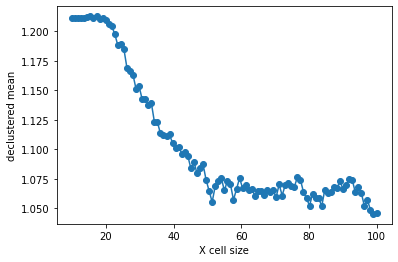

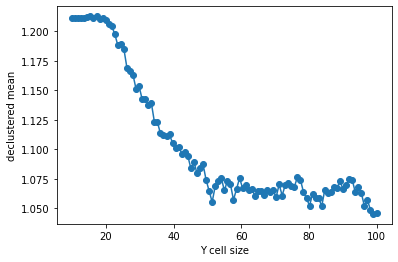

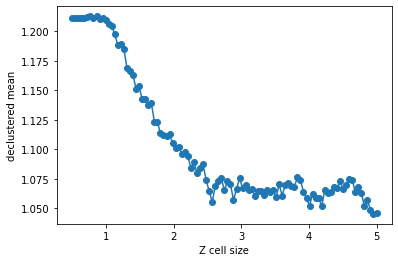

In [17]:
#declustering parameters 
parameters_declus = { 
        'x'      :  mydholes.table['cmp'].loc[:, 'xm'], 
        'y'      :  mydholes.table['cmp'].loc[:, 'ym'],  
        'z'      :  mydholes.table['cmp'].loc[:, 'zm'], 
        'vr'     :  mydholes.table['cmp'].loc[:, 'Au'],   
        'anisy'  :  1.,       
        'anisz'  :  .05,              
        'minmax' :  0,                 
        'ncell'  :  100,                  
        'cmin'   :  10., 
        'cmax'   :  100.,                 
        'noff'   :  8,                    
        'maxcel' :  -1}               

# declustering 
wtopt,vrop,wtmin,wtmax,error, \
xinc,yinc,zinc,rxcs,rycs,rzcs,rvrcr = pygslib.gslib.declus(parameters_declus)

#Plotting declustering optimization results
plt.plot (rxcs, rvrcr, '-o')
plt.xlabel('X cell size')
plt.ylabel('declustered mean')
plt.show()
plt.plot (rycs, rvrcr, '-o')
plt.xlabel('Y cell size')
plt.ylabel('declustered mean')
plt.show()
plt.plot (rzcs, rvrcr, '-o')
plt.xlabel('Z cell size')
plt.ylabel('declustered mean')
plt.show()

Now we fix the cell size to 60 x 60 x 3 

In [18]:
#declustering parameters 
parameters_declus['ncell'] = 1
parameters_declus['cmin'] = 60
parameters_declus['cmax'] = 60
   
# declustering 
wtopt,vrop,wtmin,wtmax,error, \
xinc,yinc,zinc,rxcs,rycs,rzcs,rvrcr = pygslib.gslib.declus(parameters_declus)

# Adding declustering weight to a drillhole interval table
mydholes.table['cmp']['declustwt'] = wtopt

# calculating declustered mean
decl_mean = rvrcr[0]

print ('declustered mean:', decl_mean)

declustered mean: 1.0693506510453021


### Interpolation and validation

In [19]:
# creating BHID of type integer, this is to be able to use drillhole id in Fortran!
mydholes.txt2intID('cmp')

In [20]:
# creating parameter dictionary for estimation in one block
kt3d_Parameters = {
            # Input Data (Only using intervals in the mineralized domain)
            # ----------
            'x' : mydholes.table["cmp"]['xm'].values, 
            'y' : mydholes.table["cmp"]['ym'].values,
            'z' : mydholes.table["cmp"]['zm'].values,
            'vr' : mydholes.table["cmp"]['Au'].values,
            'bhidint' : mydholes.table["cmp"]['BHIDint'].values, # an interger BHID
            # Output (Target) 
            # ----------
            'nx' : 100,  # these parameters are only used to define supperblock search
            'ny' : 100,  
            'nz' : 100, 
            'xmn' : 0,  
            'ymn' : 0,  
            'zmn' : 0,  
            'xsiz' : 5,  
            'ysiz' : 5,   
            'zsiz' : 5, 
            'nxdis' : 5,  
            'nydis' : 5,  
            'nzdis' : 3,  
            'outx' : mymodel.bmtable['XC'].values,  
            'outy' : mymodel.bmtable['YC'].values,
            'outz' : mymodel.bmtable['ZC'].values,
            # Search parameters 
            # ----------
            'radius'     : 60,   
            'radius1'    : 60,   
            'radius2'    : 8,   
            'sang1'      : 0,  
            'sang2'      : 0,   
            'sang3'      : -15,   
            'ndmax'      : 20,    
            'ndmin'      : 7,  
            'noct'       : 0,
            'nbhid'      : 5,   
            # Kriging parameters and options 
            # ----------
            'ktype'      : 1,   # 1 Ordinary kriging 
            'idbg'       : 0,   # 0 no debug 
            # Variogram parameters Pygslib
            # ----------
            'c0'         : 0.1,   
            'it'         : [1],    
            'cc'         : [.9],     
            'aa'         : [100],   
            'aa1'        : [100],  
            'aa2'        : [20],   
            'ang1'       : [0],   
            'ang2'       : [0],  
            'ang3'       : [-15]}   

In [21]:
# estimating in all blocks
estimate, debug, summary = pygslib.gslib.kt3d(kt3d_Parameters)

In [22]:
# adding the estimate into the model
mymodel.bmtable['Au_OK'] = estimate['outest']
mymodel.bmtable['Au_ID2'] = estimate['outidpower']
mymodel.bmtable['Au_NN'] = estimate['outnn']
mymodel.bmtable['Au_Lagrange'] = estimate['outlagrange']
mymodel.bmtable['Au_KVar']= estimate['outkvar']

In [23]:
# exporting block model to VTK (unstructured grid) 
mymodel.blocks2vtkUnstructuredGrid(path='bmodel.vtu')

### Validating results

Basic validations are:

 - visual validation
 - comparison of mean grades
 - swath plots 
 - global change of support (GCOS)


#### Visual validations 


#### Mean comparison

In [24]:
print ("Mean in model OK   :",  mymodel.bmtable['Au_OK'].mean())
print ("Mean in model ID2   :",  mymodel.bmtable['Au_ID2'].mean())
print ("Mean in model NN   :",  mymodel.bmtable['Au_NN'].mean())
print ("Mean in data    :", mydholes.table["cmp"]['Au'].mean())
print ("Declustered mean:", decl_mean)

Mean in model OK   : 1.0258355140686035
Mean in model ID2   : 1.0823125839233398
Mean in model NN   : 1.0184873342514038
Mean in data    : 1.211641408732144
Declustered mean: 1.0693506510453021


#### Swath plots


<AxesSubplot:xlabel='XC'>

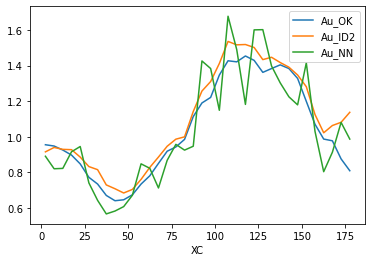

In [25]:
mymodel.bmtable.groupby('XC')[['Au_OK','Au_ID2','Au_NN']].mean().plot()

<AxesSubplot:xlabel='YC'>

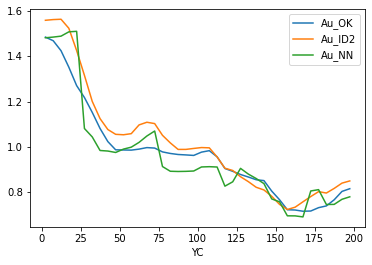

In [26]:
mymodel.bmtable.groupby('YC')[['Au_OK','Au_ID2','Au_NN']].mean().plot()

<AxesSubplot:xlabel='ZC'>

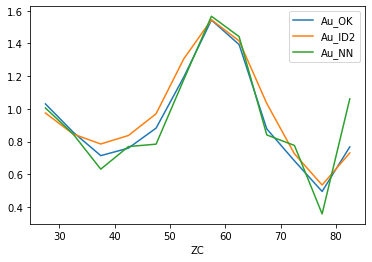

In [27]:
mymodel.bmtable.groupby('ZC')[['Au_OK','Au_ID2','Au_NN']].mean().plot()

#### Global change of support  

In [28]:
# define cutoff
cutoff = np.arange(0, 3, 0.01)
# get variance to rescale model (wich is normalized)
variance =  1

# define parameters to calculate block covariance
parameters = {
       # Coordinates of the discretization points
        'xdb'  :  np.random.uniform(0,5,size=20), # random point in block of 5 m
        'ydb'  :  np.random.uniform(0,5,size=20), # 
        'zdb'  :  np.random.uniform(0,5,size=20), # 
       # Variogram model from kriging parameters
        'c0'         :   variance * kt3d_Parameters['c0'] ,   
        'it'         :   kt3d_Parameters['it'],  
        'cc'         :   [i* variance for i in kt3d_Parameters['cc']],   
        'aa'         :   kt3d_Parameters['aa'],    
        'aa1'        :   kt3d_Parameters['aa1'],     
        'aa2'        :   kt3d_Parameters['aa2'],    
        'ang1'       :   kt3d_Parameters['ang1'],     
        'ang2'       :   kt3d_Parameters['ang2'],    
        'ang3'       :   kt3d_Parameters['ang3']}

cbb = pygslib.gslib.block_covariance(parameters)

# see parameters
print ('variance', variance)
print ('cutoff (last 5 values)', cutoff [-5:])
print ('block variance', cbb)

variance 1
cutoff (last 5 values) [2.95 2.96 2.97 2.98 2.99]
block variance 0.7844560252898028


('Raw Variance', 1.2274193080917284)
('Variance from PCI', 1.2140616494020597)
('zamin', 0.09272203139841699)
('zamax', 10.377482444472498)
('yamin', -2.2972972972972974)
('yamax', 3.328328328328329)
('zpmin', 0.05559723614809597)
('zpmax', 10.545760906190969)
('ypmin', -3.148148148148148)
('ypmax', 3.328328328328329)
('zamin blk', 0.055601504474464436)
('zamax blk', 10.545760906190969)
('yamin blk', -4.70970970970971)
('yamax blk', 4.98998998998999)
('zpmin blk', 0.05559822298580953)
('zpmax blk', 10.545760906190969)
('ypmin blk', -5.0)
('ypmax blk', 5.0)


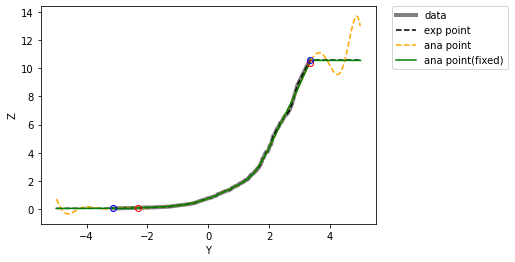

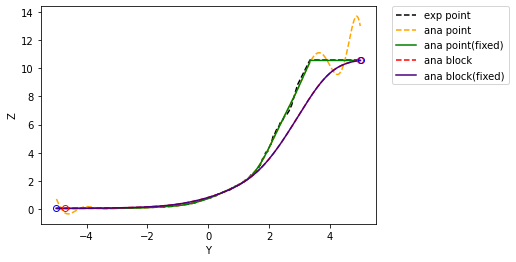

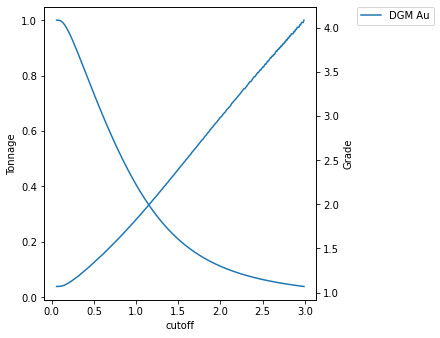

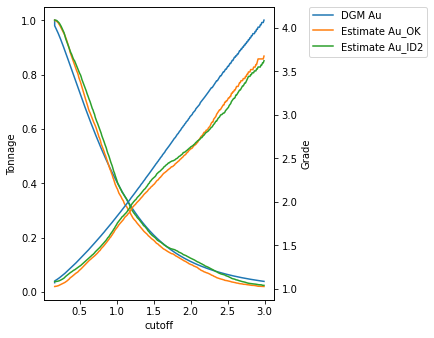

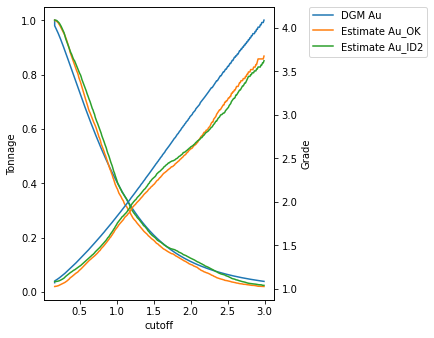

In [29]:
from pygslib.utils import gcos
gcos(mydholes.table['cmp'],  'Au', ['Au_OK','Au_ID2'], cutoff, mymodel.bmtable, cbb, decwt = 'declustwt') 